# <div style="padding: 40px;color:white;margin:10;font-size:90%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Kaggle - LLM Science Exam (deberta-v3-base)</span></b> </div>
***

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModel
from datasets import Dataset
import warnings
warnings.filterwarnings("ignore")

model_name = '/kaggle/input/debertav3base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
train = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/train.csv').drop('id', axis = 1)
test = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/test.csv')
sample = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/sample_submission.csv')

In [3]:
train.head(3)

,prompt,A,B,C,D,E,answer
0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D
1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A
2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A


In [4]:
sample.head(2)

,id,prediction
0,0,A B C
1,1,A B C


# <h1 style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>EDA</span></b> </h1>

In [5]:
new_column_names = {
    'prompt': 'Question',
    'A': 'Option_A',
    'B': 'Option_B',
    'C': 'Option_C',
    'D': 'Option_D',
    'E': 'Option_E',
    'answer': 'Answer'
}

train_d = train.copy()
train_d.rename(columns=new_column_names, inplace=True)

for column, value in train_d.iloc[0].items():
    print(f'{column}:\n\t{value}\n')

Question:
	Which of the following statements accurately describes the impact of Modified Newtonian Dynamics (MOND) on the observed "missing baryonic mass" discrepancy in galaxy clusters?

Option_A:
	MOND is a theory that reduces the observed missing baryonic mass in galaxy clusters by postulating the existence of a new form of matter called "fuzzy dark matter."

Option_B:
	MOND is a theory that increases the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 20.

Option_C:
	MOND is a theory that explains the missing baryonic mass in galaxy clusters that was previously considered dark matter by demonstrating that the mass is in the form of neutrinos and axions.

Option_D:
	MOND is a theory that reduces the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 2.

Option_E:
	M

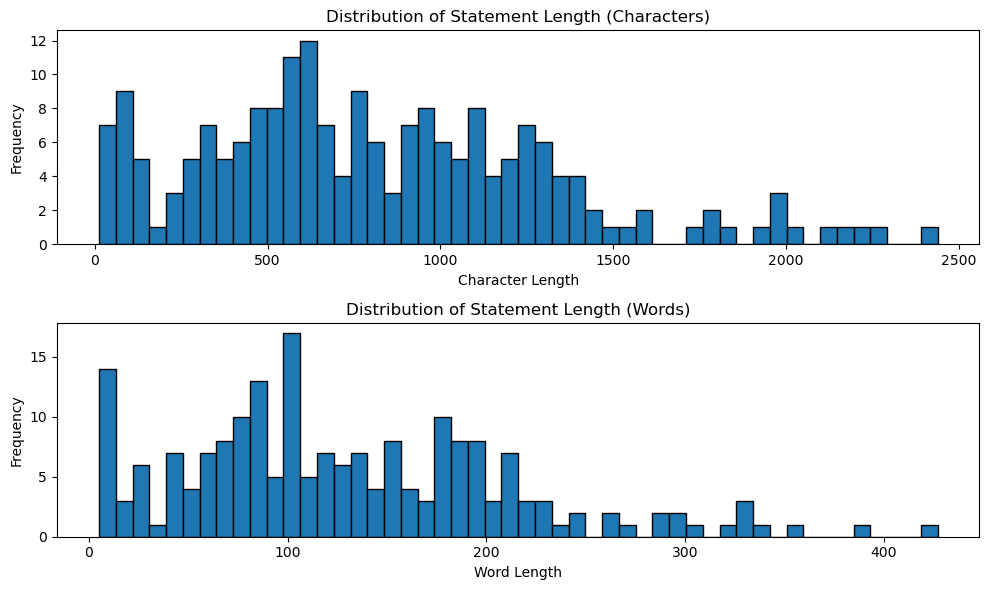

In [6]:
train_a = train.copy()
train_a['statements'] = train_a['A'] + ' ' + train_a['B'] + ' ' + train_a['C'] + ' ' + train_a['D'] + ' ' + train_a['E']
train_a['char_length'] = train_a['statements'].apply(len)
train_a['word_length'] = train_a['statements'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.hist(train_a['char_length'], bins=50, edgecolor='k')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.title('Distribution of Statement Length (Characters)')
plt.subplot(2, 1, 2)
plt.hist(train_a['word_length'], bins=50, edgecolor='k')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Statement Length (Words)')

plt.tight_layout()
plt.show()

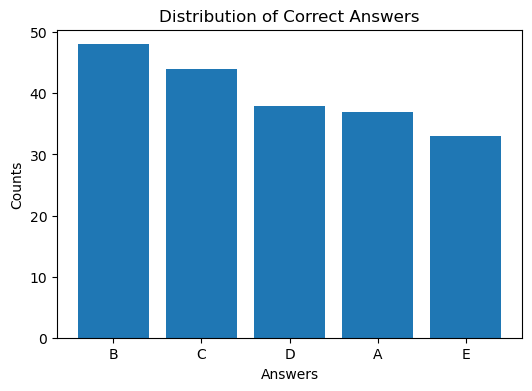

In [7]:
answer_counts = train['answer'].value_counts()
plt.figure(figsize=(6,4))
plt.bar(answer_counts.index, answer_counts.values)
plt.xlabel('Answers')
plt.ylabel('Counts')
plt.title('Distribution of Correct Answers')
plt.show()

# <h1 style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Pre-processing</span></b> </h1>

In [8]:
train_d = Dataset.from_pandas(train)
#test_d = Dataset.from_pandas(test)

In [9]:
def preprocess(example):
    first_sentence = [example['prompt']] * 5
    second_sentence = []
    for option in 'ABCDE':
        second_sentence.append(example[option])
 
    label_encoder = LabelEncoder()
    labels = ['A', 'B', 'C', 'D', 'E']
    label_encoder.fit(labels)
    encoded_label = label_encoder.transform([example['answer']])[0]

    tokenized_example = tokenizer(first_sentence, second_sentence, truncation=True)
    tokenized_example['label'] = encoded_label
    return tokenized_example

tokenized_train_ds = train_d.map(preprocess, batched=False, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])

  0%|          | 0/200 [00:00<?, ?ex/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [10]:
idx = 0
tokenized_example = tokenized_train_ds[idx]

print("Tokenized Example:")
print(tokenized_example)

print("\nOriginal Prompt:")
print(train['prompt'][idx])
print("\nOriginal Options:")
for option in 'ABCDE':
    print(train[option][idx])
print("\nEncoded Label (Answer):")
print(tokenized_example['label'])

Tokenized Example:
{'input_ids': [[1, 2597, 265, 262, 776, 3741, 7480, 4883, 262, 1239, 265, 32098, 85467, 15223, 287, 81978, 285, 277, 262, 3735, 307, 49364, 1588, 608, 23344, 2675, 309, 30038, 267, 13948, 13891, 302, 2, 38071, 691, 269, 266, 2654, 272, 6829, 262, 3735, 2367, 1588, 608, 23344, 2675, 267, 13948, 13891, 293, 600, 27866, 262, 3861, 265, 266, 353, 726, 265, 912, 650, 307, 119902, 1777, 912, 260, 309, 2], [1, 2597, 265, 262, 776, 3741, 7480, 4883, 262, 1239, 265, 32098, 85467, 15223, 287, 81978, 285, 277, 262, 3735, 307, 49364, 1588, 608, 23344, 2675, 309, 30038, 267, 13948, 13891, 302, 2, 38071, 691, 269, 266, 2654, 272, 3441, 262, 30038, 457, 262, 3735, 2367, 1588, 608, 23344, 2675, 267, 13948, 13891, 263, 262, 4836, 11798, 28929, 268, 292, 266, 2641, 265, 441, 466, 264, 266, 2641, 265, 314, 602, 260, 2], [1, 2597, 265, 262, 776, 3741, 7480, 4883, 262, 1239, 265, 32098, 85467, 15223, 287, 81978, 285, 277, 262, 3735, 307, 49364, 1588, 608, 23344, 2675, 309, 30038, 267, 13

In [11]:
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch

@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        label_name = "label" if 'label' in features[0].keys() else 'labels'
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]['input_ids'])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors='pt',
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        return batch

# <h1 style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Model</span></b> </h1>

In [12]:
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
model = AutoModelForMultipleChoice.from_pretrained(model_name)

Some weights of the model checkpoint at /kaggle/input/debertav3base were not used when initializing DebertaV2ForMultipleChoice: ['lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2ForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassi

In [13]:
model_name = 'finetuned_bert'
training_args = TrainingArguments(
    output_dir=model_name,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=7,
    weight_decay=0.01,
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_train_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer),
)

trainer.train()

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,1.582883
2,No log,1.302669
3,No log,1.049053
4,No log,0.796345
5,No log,0.694087
6,No log,0.576505
7,No log,0.515552


TrainOutput(global_step=175, training_loss=1.1204052734375, metrics={'train_runtime': 179.9797, 'train_samples_per_second': 7.779, 'train_steps_per_second': 0.972, 'total_flos': 330310110214320.0, 'train_loss': 1.1204052734375, 'epoch': 7.0})

In [14]:
predictions = trainer.predict(tokenized_train_ds)

# <h1 style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Post-Processing</span></b> </h1>

In [15]:
options = 'ABCDE'
indices = list(range(5))
index_to_option = {index: option for option, index in zip(options, indices)}

def predictions_to_map_output(predictions):    
    top_answer_indices = np.argpartition(-predictions, kth=3, axis=-1)[:, :3]
    top_answers = np.vectorize(index_to_option.get)(top_answer_indices)
    submission_results = np.apply_along_axis(lambda row: ' '.join(row), 1, top_answers)

    return submission_results

In [16]:
test['answer'] = 'A'
test_ds = Dataset.from_pandas(test)
tokenized_test_ds = test_ds.map(preprocess, batched=False, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])

  0%|          | 0/200 [00:00<?, ?ex/s]

In [17]:
test_predictions = trainer.predict(tokenized_test_ds)
submission_df = test[['id']]
submission_df['prediction'] = predictions_to_map_output(test_predictions.predictions)
submission_df.to_csv('submission.csv', index=False)